In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time

class MLP():
    def __init__(self,X,Y,X_val,Y_val,L=1,N_l=128):
        self.X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
        self.Y = self.one_hot_encode(Y, 2)  
        self.X_val = np.concatenate((X_val,np.ones((X_val.shape[0],1))),axis=1)
        self.Y_val = self.one_hot_encode(Y_val, 2)  
        self.L = L
        self.N_l = N_l
        self.n_samples = self.X.shape[0]
        self.layer_sizes = np.array([self.X.shape[1]]+[N_l]*L+[self.Y.shape[1]])
        self.__init_weights()
        self.train_loss = list()
        self.train_acc = list()
        self.val_loss = list()
        self.val_acc = list()
        self.train_time = list()
        self.tot_time = list()
        self.metrics = [self.train_loss,self.train_acc,self.val_loss,self.val_acc,self.train_time,self.tot_time]

    def one_hot_encode(self, labels, num_classes):
        one_hot = np.zeros((len(labels), num_classes))
        one_hot[np.arange(len(labels)), labels] = 1
        return one_hot

    def __sigmoid(self,x):
        return 1./(1.+np.exp(-x))

    def __softmax(self,x):
        exponent = np.exp(x)
        return exponent/exponent.sum(axis=1,keepdims=True)

    def __loss(self,y_pred,y):
        return ((-np.log(y_pred))*y).sum(axis=1).mean()

    def __accuracy(self, y_pred, y):
      if isinstance(y_pred, np.ndarray) and y_pred.ndim > 1 and y_pred.shape[1] > 1:  
          y_pred = np.argmax(y_pred, axis=1)
      if y.ndim > 1:  
          y = np.argmax(y, axis=1)
      return np.mean(y_pred == y)

    def __sigmoid_prime(self,h):
        return h*(1-h)

    def __to_categorical(self,x):
        categorical = np.zeros((x.shape[0],self.Y.shape[1]))
        categorical[np.arange(x.shape[0]),x.argmax(axis=1)] = 1
        return categorical

    def __init_weights(self):
        self.weights = []
        for i in range(self.layer_sizes.shape[0]-1):
            fan_in = self.layer_sizes[i]
            fan_out = self.layer_sizes[i+1]
            limit = np.sqrt(6 / (fan_in + fan_out))  
            weight_matrix = np.random.uniform(-limit, limit, size=(fan_in, fan_out))
            # debug
            print("Weight matrix shape:", weight_matrix.shape)  
            self.weights.append(weight_matrix)

    def __init_layers(self,batch_size):
        self.__h = [np.empty((batch_size,layer)) for layer in self.layer_sizes]

    def __feed_forward(self,batch):
        h_l = batch
        self.__h[0] = h_l
        for i,weights in enumerate(self.weights):
            h_l = self.__sigmoid(h_l.dot(weights))
            self.__h[i+1]=h_l
        self.__out = self.__softmax(self.__h[-1])

    def __back_prop(self,batch_y):
        delta_t = (self.__out - batch_y)*self.__sigmoid_prime(self.__h[-1])
        for i in range(1,len(self.weights)+1):
            self.weights[-i]-=self.lr*(self.__h[-i-1].T.dot(delta_t))/self.batch_size
            delta_t = self.__sigmoid_prime(self.__h[-i-1])*(delta_t.dot(self.weights[-i].T))

    def predict(self,X):
        X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
        self.__init_layers(X.shape[0])
        self.__feed_forward(X)
        return self.__to_categorical(self.__out)
    def evaluate(self, X, Y):
      prediction = self.predict(X)
      if prediction.shape[-1] > 1:  
          prediction = np.argmax(prediction, axis=-1)
      if isinstance(Y, pd.Series):  
          Y = Y.values
      return self.__accuracy(prediction, Y)

    def train(self,batch_size=8,epochs=25,lr=1.0):
        self.lr = lr
        self.batch_size=batch_size
        for epoch in range(epochs):
            start = time.time()

            self.__init_layers(self.batch_size)
            shuffle = np.random.permutation(self.n_samples)
            train_loss = 0
            train_acc = 0
            X_batches = np.array_split(self.X[shuffle],self.n_samples//self.batch_size)  
            Y_batches = np.array_split(self.Y[shuffle],self.n_samples//self.batch_size)  
            for batch_x,batch_y in zip(X_batches,Y_batches):
                self.__feed_forward(batch_x)
                train_loss += self.__loss(self.__out,batch_y)
                train_acc += self.__accuracy(self.__to_categorical(self.__out),batch_y)
                self.__back_prop(batch_y)

            train_loss = (train_loss/len(X_batches))
            train_acc = (train_acc/len(X_batches))
            self.train_loss.append(train_loss)
            self.train_acc.append(train_acc)

            train_time = round(time.time()-start,3)
            self.train_time.append(train_time)

            self.__init_layers(self.X_val.shape[0])
            self.__feed_forward(self.X_val)
            val_loss = self.__loss(self.__out,self.Y_val)
            val_acc = self.__accuracy(self.__to_categorical(self.__out),self.Y_val)
            self.val_loss.append(val_loss)
            self.val_acc.append(val_acc)

            tot_time = round(time.time()-start,3)
            self.tot_time.append(tot_time)

            print(f"Epoch {epoch+1}: loss = {train_loss.round(3)} | acc = {train_acc.round(3)} | val_loss = {val_loss.round(3)} | val_acc = {val_acc.round(3)} | train_time = {train_time} | tot_time = {tot_time}")


In [32]:
titanic_data = pd.read_csv('dataset/train.csv')
titanic_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)
titanic_data = pd.get_dummies(titanic_data, columns=['Sex'], drop_first=True)
titanic_data['Age'].fillna(titanic_data['Age'].median(), inplace=True)
titanic_data['Fare'].fillna(titanic_data['Fare'].median(), inplace=True)

X = titanic_data.drop('Survived', axis=1)
y = titanic_data['Survived']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

mlp_model = MLP(X_train, y_train, X_val, y_val, L=1, N_l=128)
mlp_model.train(batch_size=8, epochs=25, lr=1.0)

accuracy = mlp_model.evaluate(X_val, y_val)
print("Validation Accuracy:", accuracy)


Weight matrix shape: (7, 128)
Weight matrix shape: (128, 2)
Epoch 1: loss = 0.637 | acc = 0.624 | val_loss = 0.596 | val_acc = 0.608 | train_time = 0.012 | tot_time = 0.013
Epoch 2: loss = 0.553 | acc = 0.748 | val_loss = 0.516 | val_acc = 0.78 | train_time = 0.011 | tot_time = 0.011
Epoch 3: loss = 0.52 | acc = 0.795 | val_loss = 0.507 | val_acc = 0.817 | train_time = 0.011 | tot_time = 0.011
Epoch 4: loss = 0.512 | acc = 0.794 | val_loss = 0.498 | val_acc = 0.817 | train_time = 0.011 | tot_time = 0.011
Epoch 5: loss = 0.509 | acc = 0.798 | val_loss = 0.498 | val_acc = 0.813 | train_time = 0.011 | tot_time = 0.012
Epoch 6: loss = 0.51 | acc = 0.8 | val_loss = 0.498 | val_acc = 0.817 | train_time = 0.013 | tot_time = 0.015
Epoch 7: loss = 0.504 | acc = 0.803 | val_loss = 0.496 | val_acc = 0.787 | train_time = 0.033 | tot_time = 0.034
Epoch 8: loss = 0.507 | acc = 0.796 | val_loss = 0.494 | val_acc = 0.806 | train_time = 0.029 | tot_time = 0.031
Epoch 9: loss = 0.506 | acc = 0.801 | val

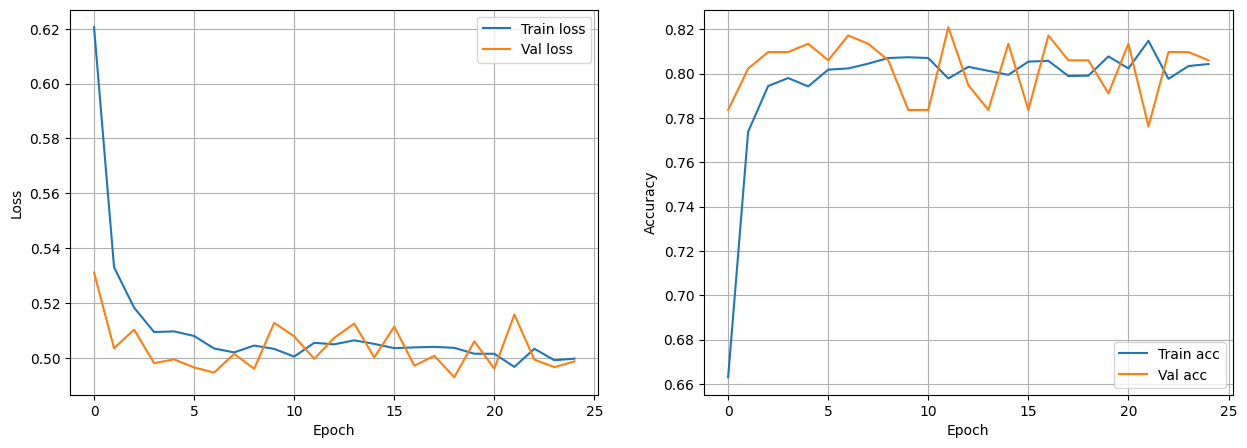

In [31]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(mlp_model.train_loss,label="Train loss")
ax[0].plot(mlp_model.val_loss,label="Val loss")
ax[0].legend()
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()

ax[1].plot(mlp_model.train_acc,label="Train acc")
ax[1].plot(mlp_model.val_acc,label="Val acc")
ax[1].legend()
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()